In [1]:
import aacgmv2
import os
import sys
import psycopg2

import datetime as dt
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mpl_toolkits.basemap import Basemap
from itertools import chain
from tqdm import tqdm

import utils
from utils import local_data
from utils import window

%matplotlib inline

latter_size = 14
plt.rcParams['legend.fontsize'] = latter_size 
plt.rcParams['font.size'] = latter_size 
plt.rcParams['axes.labelsize'] = latter_size
plt.rcParams['xtick.labelsize'] = latter_size
plt.rcParams['ytick.labelsize'] = latter_size

In [2]:
df_series_vtec = pd.read_pickle(os.path.join(local_data, "station_data_series_tec.pkl.xz"), compression='xz')
df_series_s4 = pd.read_pickle(os.path.join(local_data, "df_series_s4.pkl.xz"), compression='xz')
df_station = pd.read_pickle(os.path.join(local_data, 'df_station_sort.pkl'))

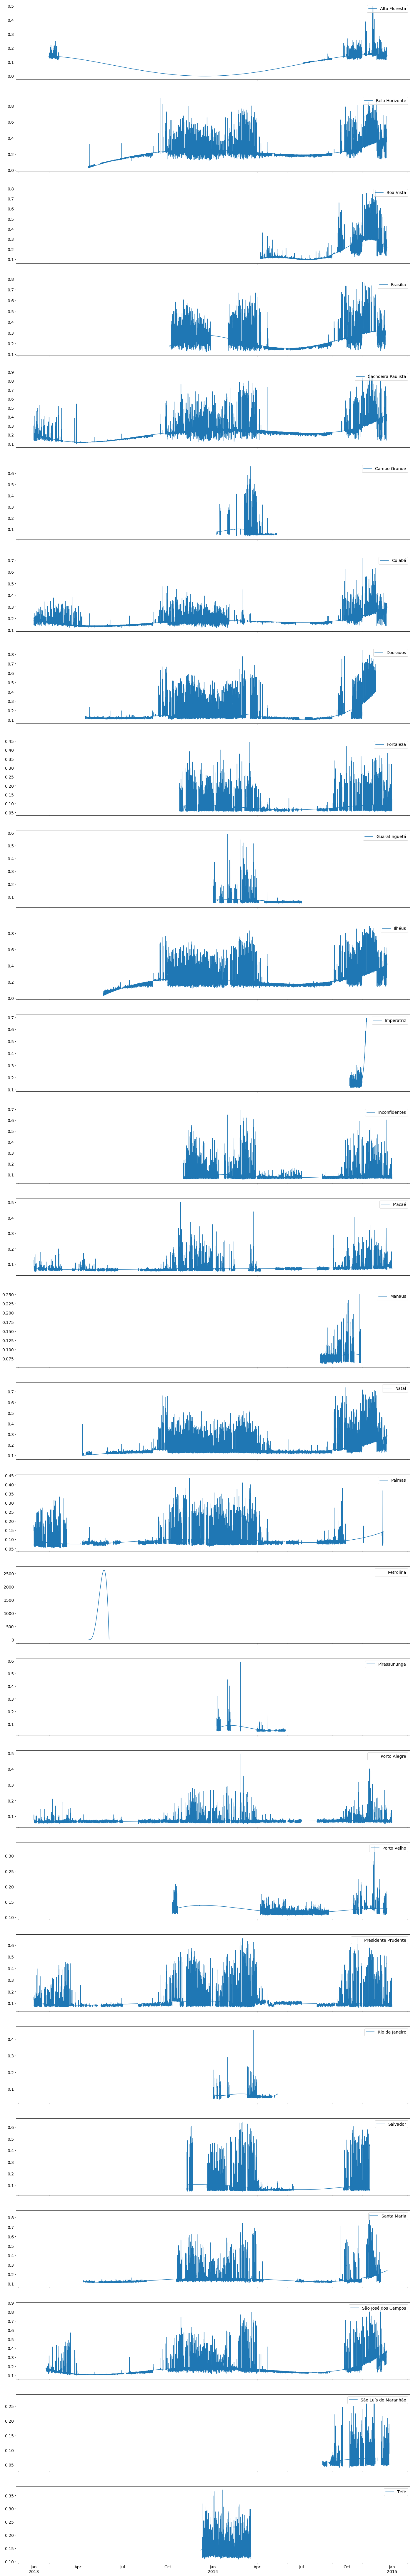

In [3]:
size = df_series_s4.columns.size
fig, ax = plt.subplots(size, 1, sharex=True)
for idx, i in enumerate(df_series_s4.columns):
    name = df_station.loc[df_station['identificationstation'] == i].index[0]
    df_series_s4[i].plot(figsize=(24, 160), ax=ax[idx], label=name)
    ax[idx].legend(loc="upper right")

Analisando os dados os gráficos acima, optou-se por descartar as estações de Petrolina e Imperatriz, cujos idenfiticadores são respectivamentes 'pln' e 'imp'.

In [4]:
remove = ['imp', 'pln']
for i in remove:
    df_station = df_station[df_station.identificationstation != i]
    del df_series_s4[i]
    del df_series_vtec[i]
    

In [5]:
df_station

identificationstation    height   latitude  longitude  \
city_name_correct                                                            
Alta Floresta                          afl   267.000  -9.870000 -55.900000   
Belo Horizonte                         bhz   858.000 -19.868500 -43.954200   
Boa Vista                              bov    69.180   2.833920 -60.695380   
Brasília                               bsa  1050.000 -15.764200 -47.869400   
Cachoeira Paulista                     cpa   580.000 -22.410000 -45.000000   
Campo Grande                            32       NaN -20.497000 -54.615000   
Cuiabá                                 cub   278.000 -15.555200 -56.069800   
Dourados                               dou   756.120 -22.110000 -54.550000   
Fortaleza                               24       NaN  -3.742000 -38.539000   
Guaratinguetá                           33       NaN -22.789000 -45.220000   
Ilhéus                                 ios     0.000 -14.470000 -39.100000   
Inconfidentes                           25       NaN -22.318000 -46.329000   
Macaé                                   11       NaN -22.823000 -41.785700   
Manaus                                  28       NaN  -3.100000 -59.976000   
Natal                                  nta     0.000  -5.836162 -35.121000   
Palmas                                   3       NaN -10.200000 -48.312000   
Pirassununga                            30       NaN -21.989000 -47.334000   
Porto Alegre                             4       NaN -30.071000 -51.119000   
Porto Velho                            pvh  1130.000  -8.490000 -63.550000   
Presidente Prudente                      6       NaN -22.120000 -51.407000   
Rio de Janeiro                          34       NaN -22.823000 -43.238000   
Salvador                                26       NaN -13.001000 -38.508000   
Santa Maria                            sta   110.100 -29.712591 -53.717206   
São José dos Campos                    sj2   593.440 -23.207000 -45.859000   
São Luís do Maranhão                    29       NaN  -2.574000 -44.209000   
Tefé                                   tfe     0.057  -3.180000 -64.440000   

                     state                                      city  \
city_name_correct                                                      
Alta Floresta           mt                             alta floresta   
Belo Horizonte          mg                            belo horizonte   
Boa Vista               rr                                 boa vista   
Brasília                df                                  brasilia   
Cachoeira Paulista      sp                        cachoeira paulista   
Campo Grande            ms                             campos grande   
Cuiabá                  mt                                    cuiaba   
Dourados                ms                                  dourados   
Fortaleza               ce                                 fortaleza   
Guaratinguetá           sp                            guaratinguestá   
Ilhéus                  ba                                    ilheus   
Inconfidentes           mg                             inconfidentes   
Macaé                   rj                                     macaé   
Manaus                  am                                    manaus   
Natal                   rn                                     natal   
Palmas                  ro                                    palmas   
Pirassununga            sp  academia das forças aérias, pirassununga   
Porto Alegre            rs                              porto alegre   
Porto Velho             ro                               porto velho   
Presidente Prudente     sp                       presidente prudente   
Rio de Janeiro          rj         rio de janeiro (aeroporto galeão)   
Salvador                ba                                  salvador   
Santa Maria             rs                               santa maria   
São José dos Campos     sp          

In [6]:
print(df_station[['state', 'identificationstation', 'height', 'latitude', 'longitude', 'mag_latitude', 'mag_longitude', 'city_heigh', 'city_latitude', 'city_longitude']].to_latex())

\begin{tabular}{lllrrrrrrrr}
\toprule
{} & state & identificationstation &    height &   latitude &  longitude &  mag\_latitude &  mag\_longitude &  city\_heigh &  city\_latitude &  city\_longitude \\
city\_name\_correct    &       &                       &           &            &            &               &                &             &                &                 \\
\midrule
Alta Floresta        &    mt &                   afl &   267.000 &  -9.870000 & -55.900000 &    -11.812189 &      16.212312 &       264.0 &       -9.90000 &        -55.9000 \\
Belo Horizonte       &    mg &                   bhz &   858.000 & -19.868500 & -43.954200 &    -25.426147 &      24.786619 &       767.0 &      -19.81570 &        -43.9542 \\
Boa Vista            &    rr &                   bov &    69.180 &   2.833920 & -60.695380 &     11.622177 &      14.848847 &        76.0 &        2.81954 &        -60.6714 \\
Brasília             &    df &                   bsa &  1050.000 & -15.764200 & -47.

Os dados de S4 englobam dois anos inteiros, o período começando em janeiro de 2013 e terminando em janeiro de 2015. Os dados de vtec por sua vez, restrigem-se a um intervalo menor. Assim, é necessário realizar um corte na série de dados de S4, de forma a ter o mesmo número de analises.

In [7]:
first_date = df_series_vtec.index[0].to_pydatetime()
last_date = df_series_vtec.index[-1].to_pydatetime()
df_series_vtec.shape

(12960, 26)

In [8]:
df_series_s4 = df_series_s4.ix[first_date:last_date]
df_series_s4.shape

/usr/local/anaconda/envs/dscience/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


(12960, 26)

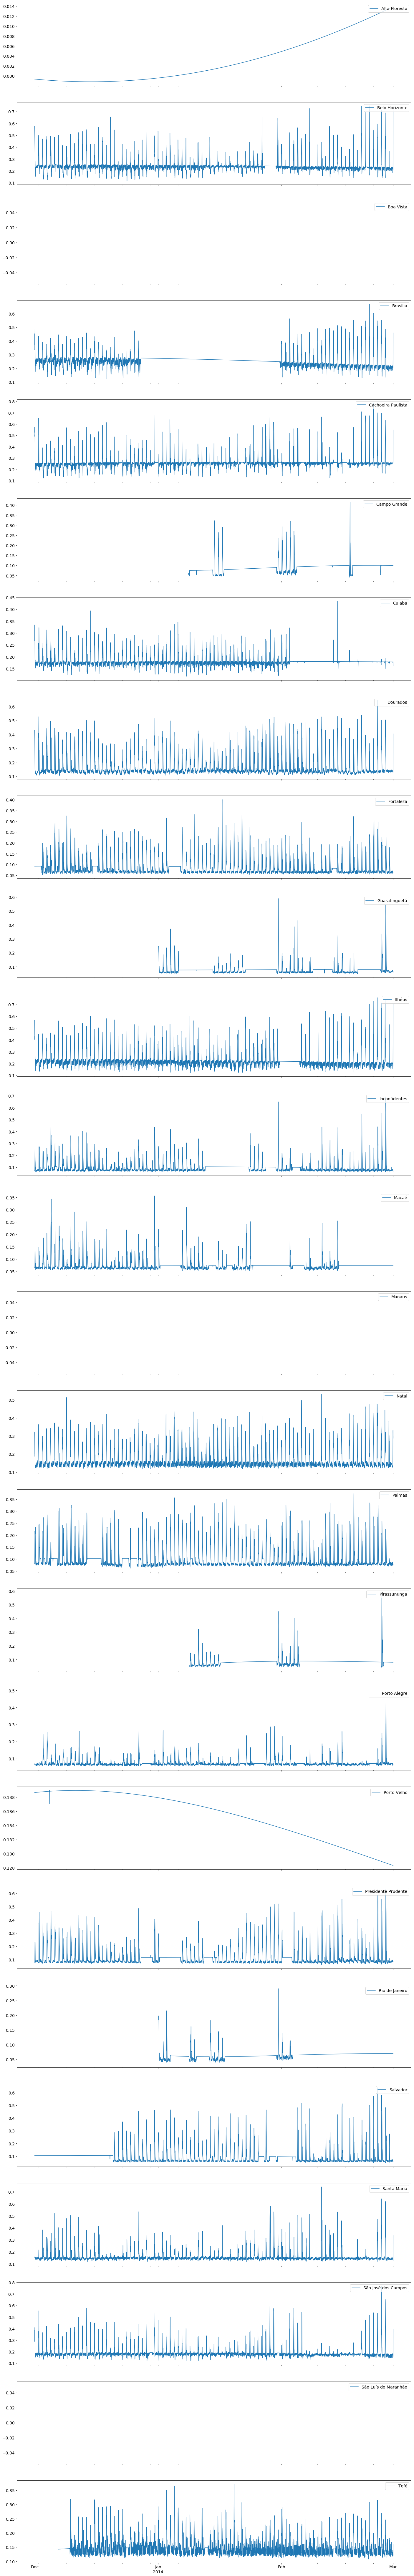

In [9]:
size = df_series_s4.columns.size
fig, ax = plt.subplots(size, 1, sharex=True)
for idx, i in enumerate(df_series_s4.columns):
    name = df_station.loc[df_station['identificationstation'] == i].index[0]
    df_series_s4[i].plot(figsize=(24, 160), ax=ax[idx], label=name)
    ax[idx].legend(loc="upper right")


In [10]:
remove = ['afl', 'bov', '28', 'pvh', '29']
for i in remove:
    df_station = df_station[df_station.identificationstation != i]
    del df_series_s4[i]
    del df_series_vtec[i]

In [11]:
size = df_series_s4.columns.size//3
groups = []
for i in range (0, 21, 7):
    groups.append(df_series_s4.columns.ravel()[i:i+7])


In [12]:
figsize = (24, 40)
latter_size = 14

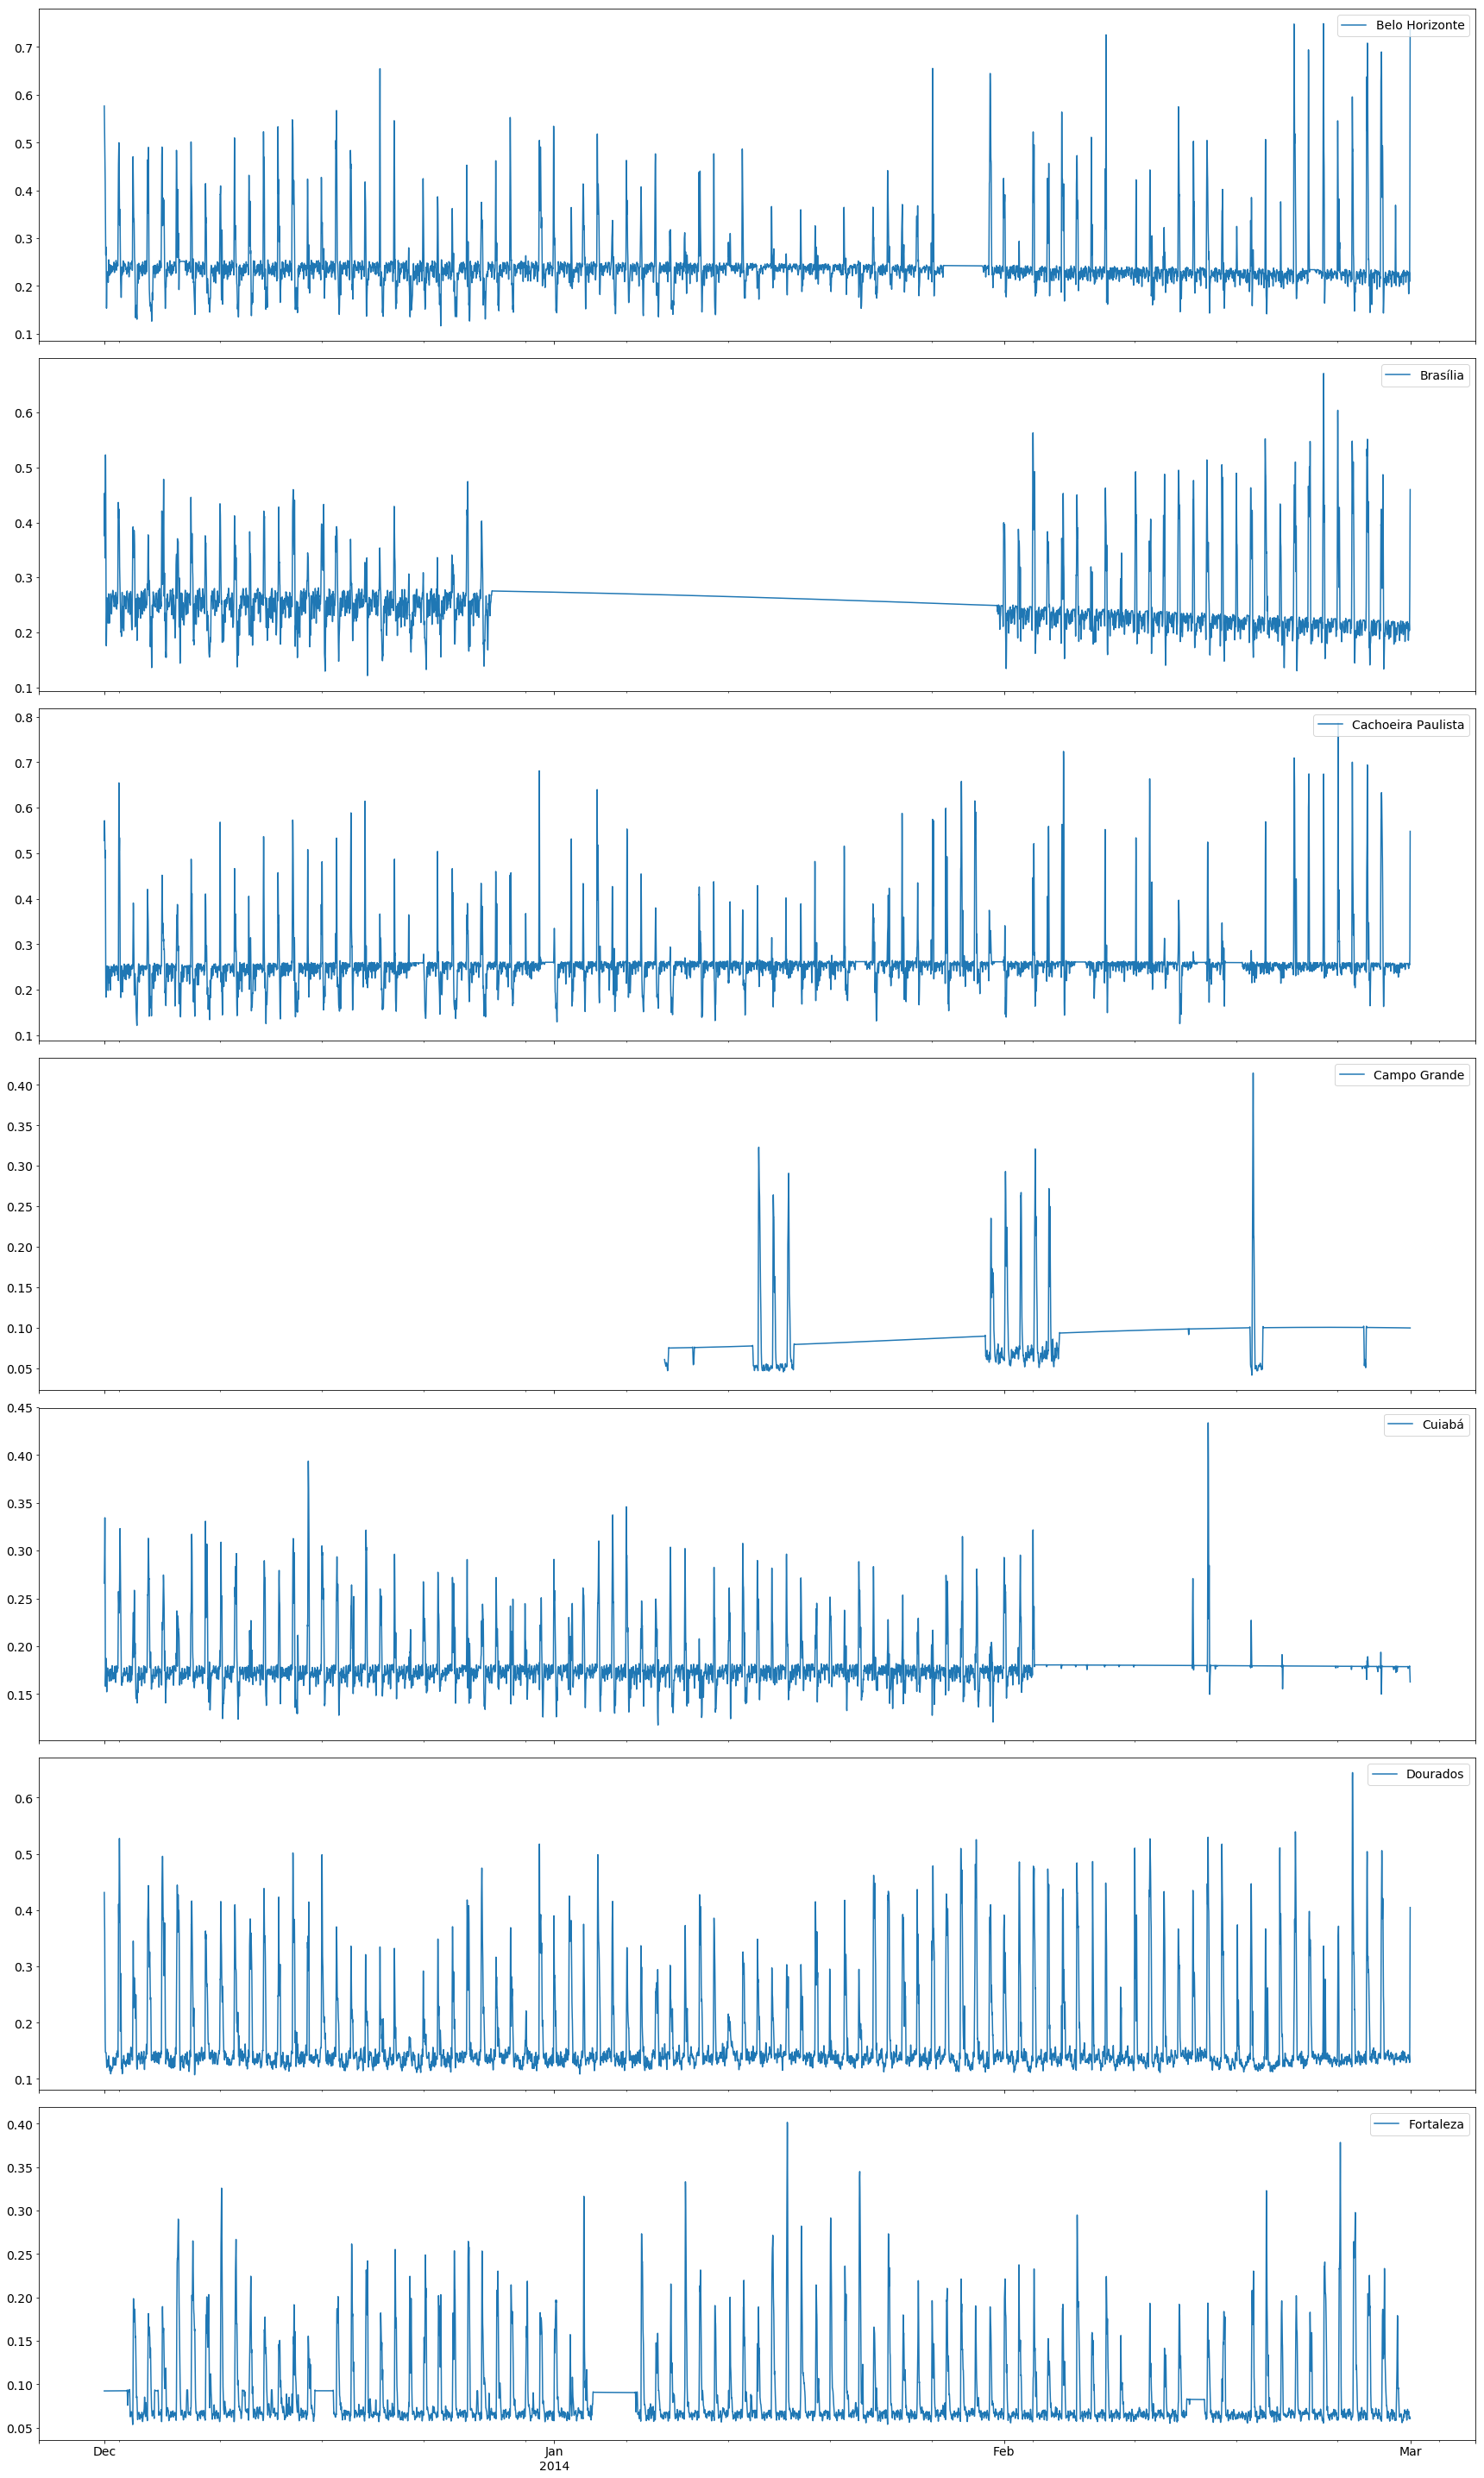

In [13]:
fig, ax = plt.subplots(size, 1, sharex=True)
for idx, i in enumerate(groups[0]):
    name = df_station.loc[df_station['identificationstation'] == i].index[0]
    df_series_s4[i].plot(figsize=figsize, ax=ax[idx], label=name)
    ax[idx].legend(loc="upper right", prop={'size': latter_size})
    ax[idx].tick_params(axis='both', which='both', labelsize=latter_size)
plt.tight_layout()
plt.savefig('./images/s4_stations0.eps', format='eps', dpi=1000)

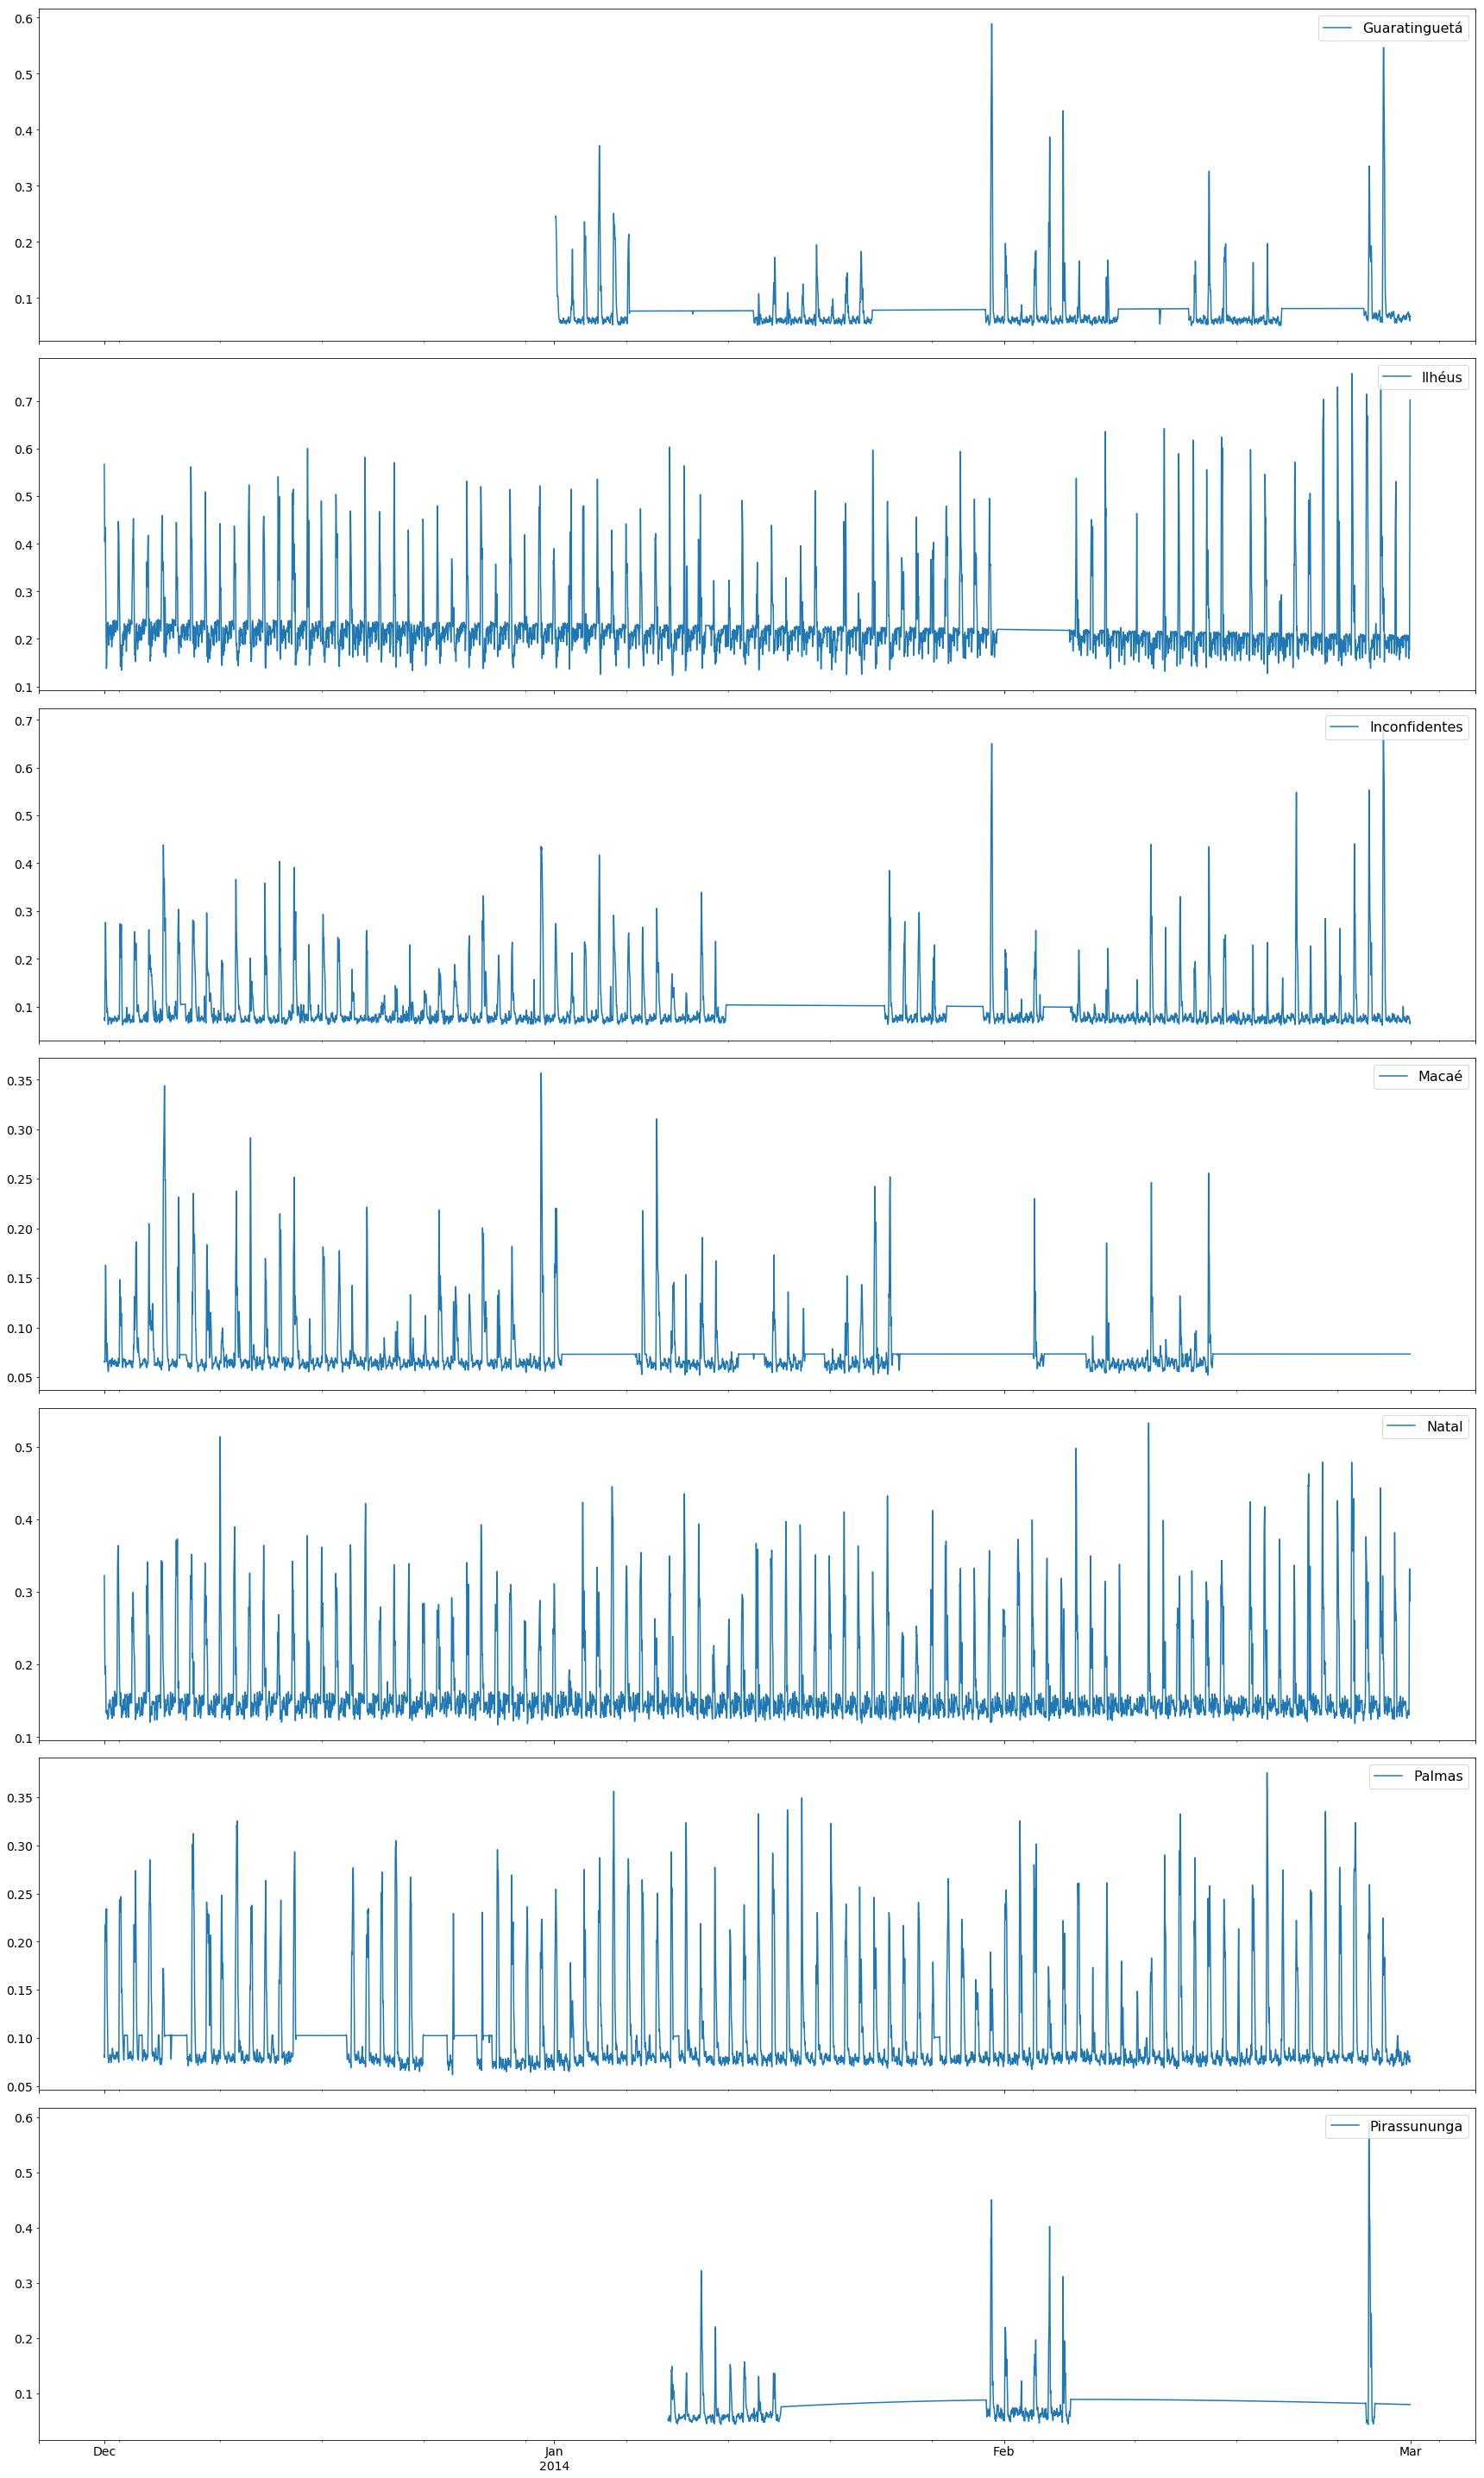

In [14]:
fig, ax = plt.subplots(size, 1, sharex=True)
for idx, i in enumerate(groups[1]):
    name = df_station.loc[df_station['identificationstation'] == i].index[0]
    df_series_s4[i].plot(figsize=figsize, ax=ax[idx], label=name)
    ax[idx].legend(loc="upper right", prop={'size': 16})
    ax[idx].tick_params(axis='both', which='both', labelsize=latter_size)
plt.tight_layout()
plt.savefig('./images/s4_stations1.eps', format='eps', dpi=1000)

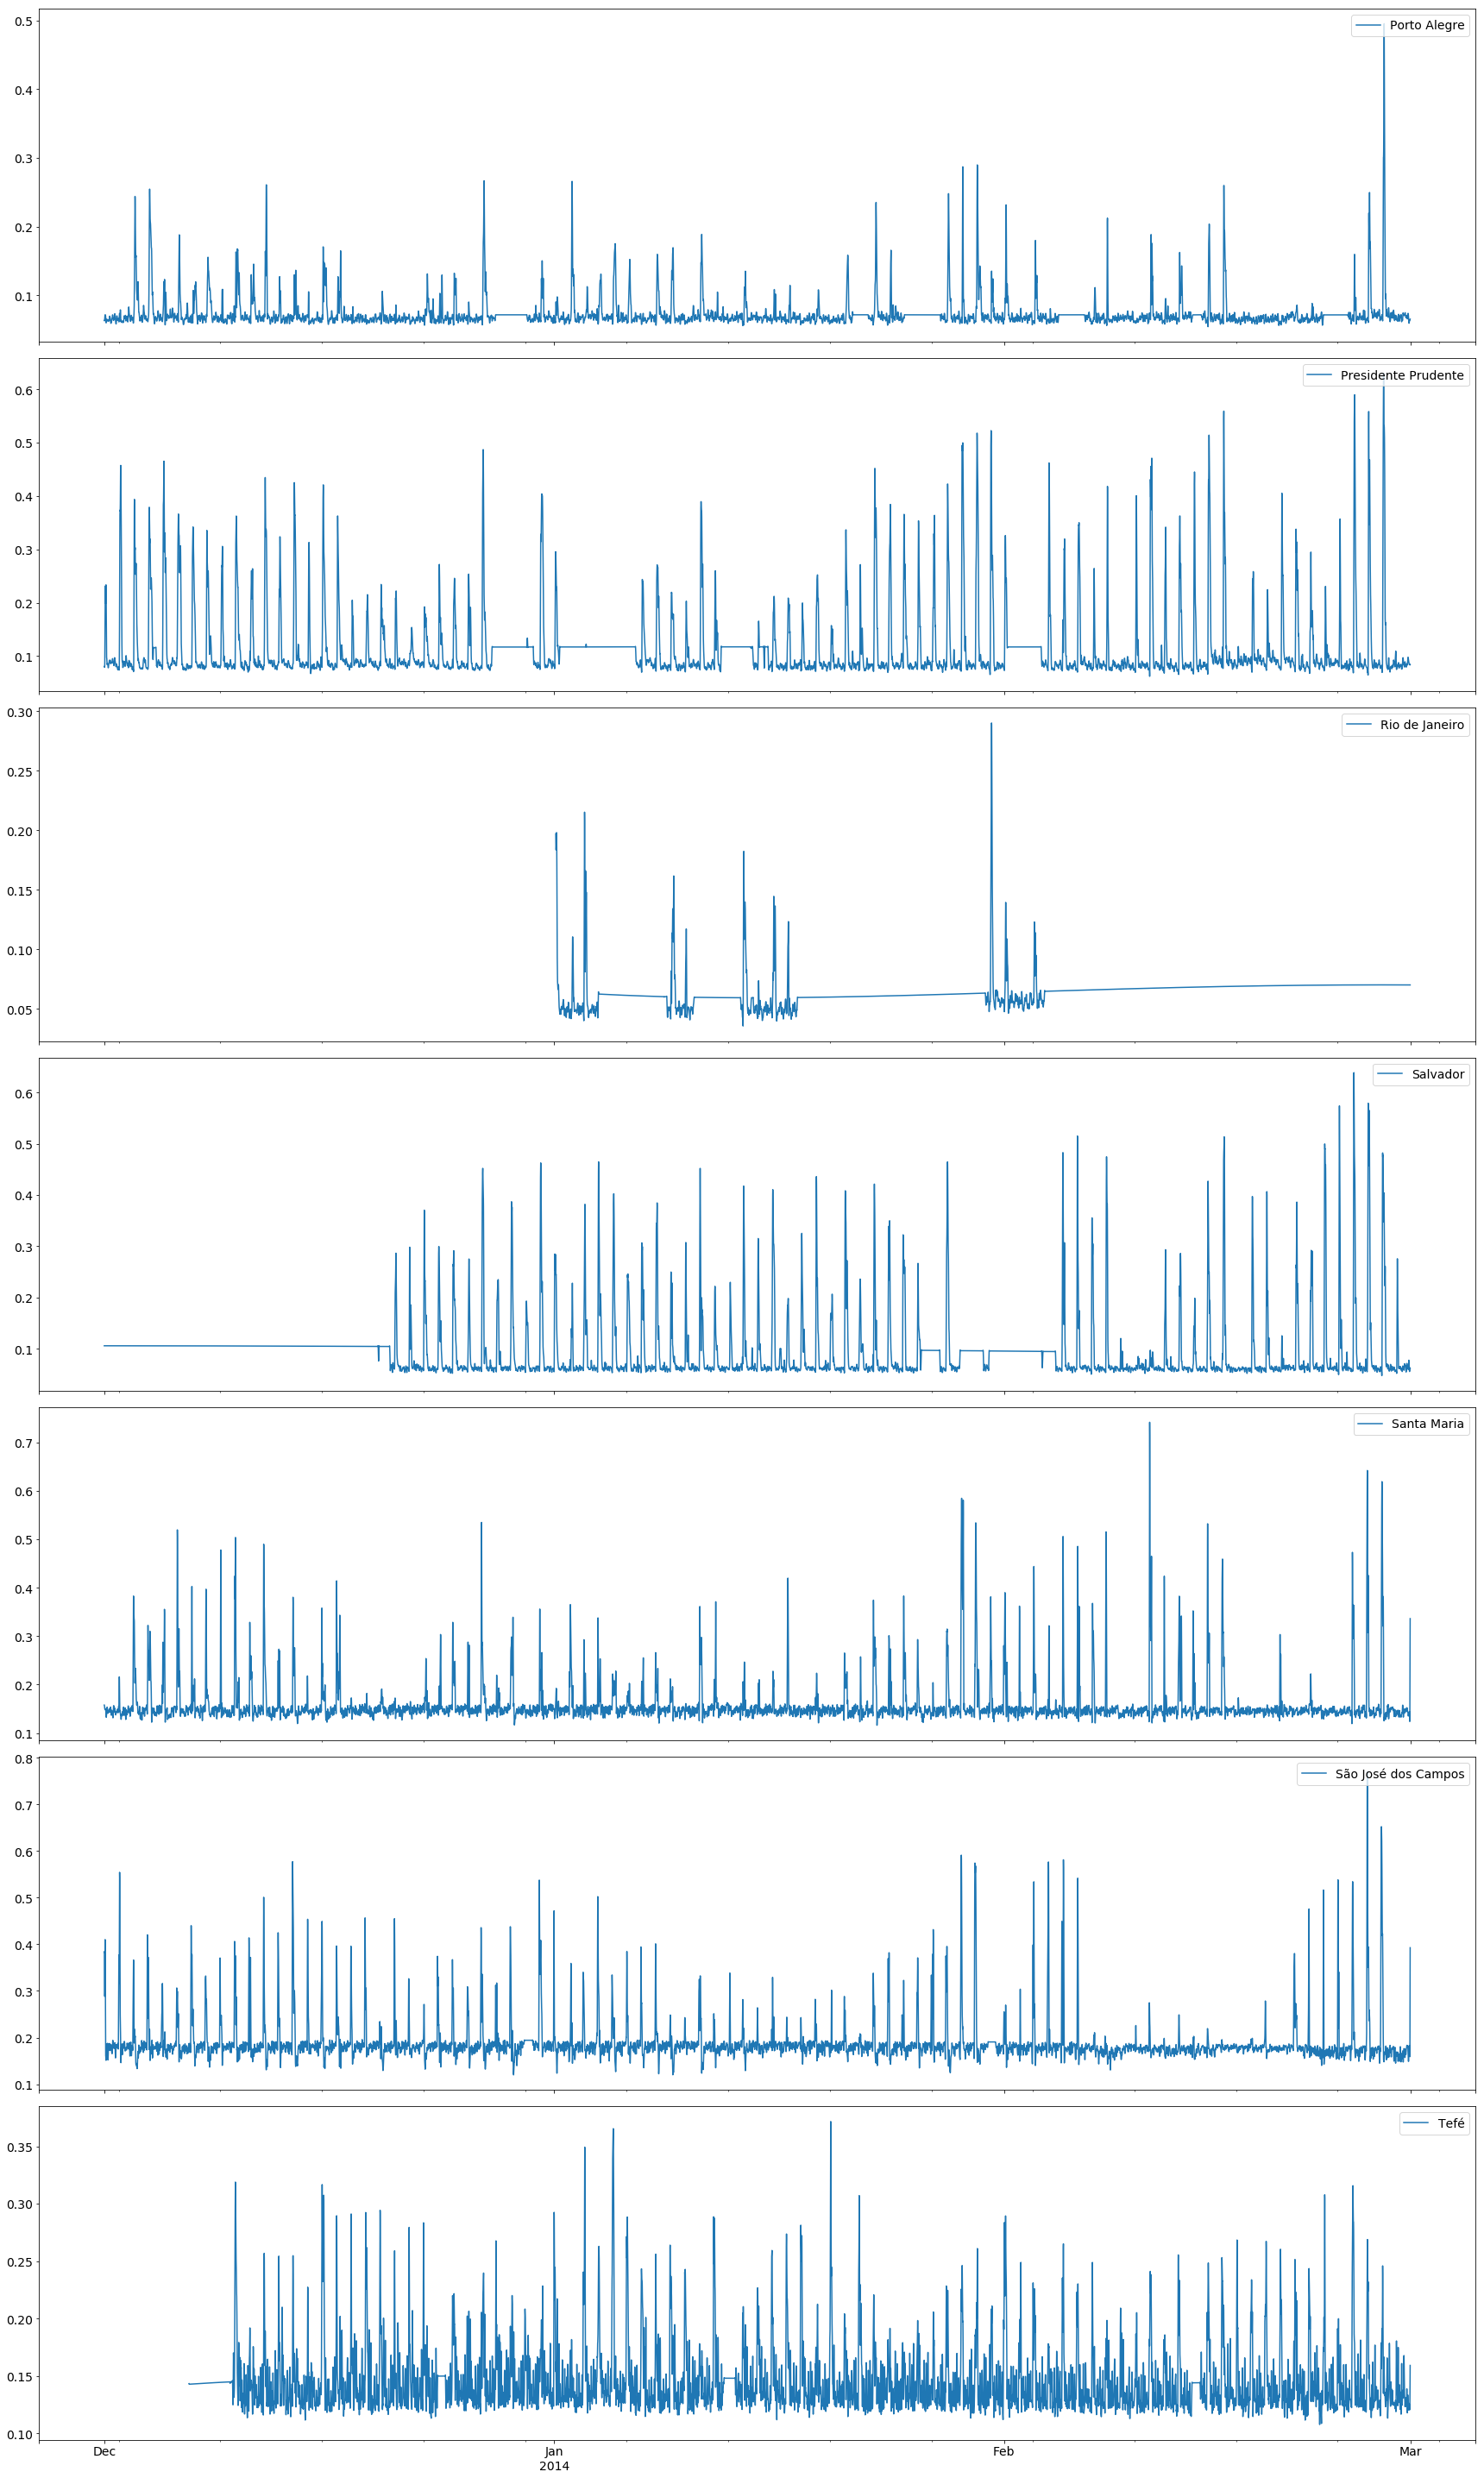

In [15]:
fig, ax = plt.subplots(size, 1, sharex=True)
for idx, i in enumerate(groups[2]):
    name = df_station.loc[df_station['identificationstation'] == i].index[0]
    df_series_s4[i].plot(figsize=figsize, ax=ax[idx], label=name)
    ax[idx].legend(loc="upper right", prop={'size': latter_size})
    ax[idx].tick_params(axis='both', which='both', labelsize=latter_size)
plt.tight_layout()
plt.savefig('./images/s4_stations2.eps', format='eps', dpi=1000)

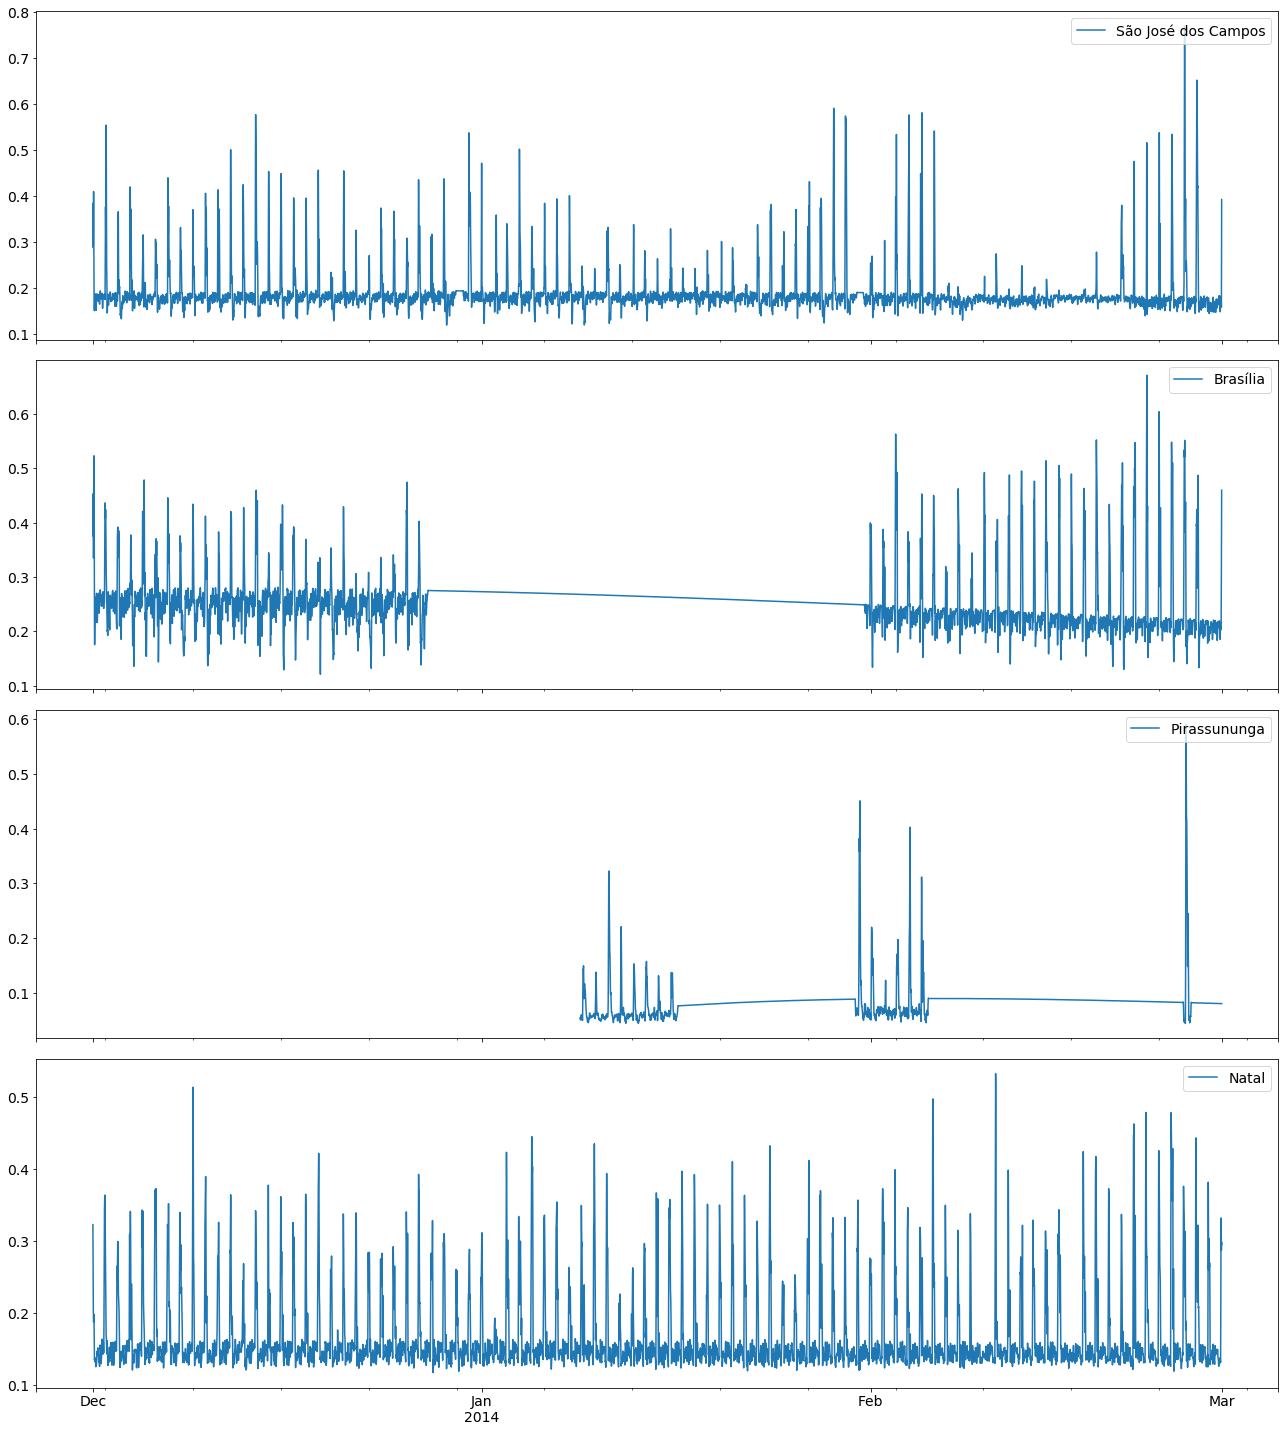

In [16]:
df_series_s4_sample = df_series_s4[['sj2', 'bsa', '30', 'nta']]
figsize = (18, 20)

fig, ax = plt.subplots(4, 1, sharex=True)
for idx, i in enumerate(df_series_s4_sample):
    name = df_station.loc[df_station['identificationstation'] == i].index[0]
    df_series_s4_sample[i].plot(figsize=figsize, ax=ax[idx], label=name)
    ax[idx].legend(loc="upper right", prop={'size': latter_size})
    ax[idx].tick_params(axis='both', which='both', labelsize=latter_size)
plt.tight_layout()
plt.savefig('./images/s4_stations_sample.eps', format='eps', dpi=1000)

In [17]:
df_series_vtec.to_pickle(os.path.join(local_data, "df_series_tec_re.pkl.xz"), compression='xz')
df_series_s4.to_pickle(os.path.join(local_data, "df_series_s4_re.pkl.xz"), compression='xz')
df_station.to_pickle(os.path.join(local_data, 'df_station_sort_re.pkl'))

In [18]:
mag_lat = df_station['mag_latitude'].values.ravel()
mag_lon = df_station['mag_longitude'].values.ravel()

dtime = dt.datetime(2013, 1, 1)
mag_meridians_lines = []
for lat, lon in zip(mag_lat, mag_lon):
    lats = np.linspace(-90, 90, 720)
    aux_geo_lat = []
    aux_geo_lon = []
    for i in lats:
        geo_lat, geo_lon, _ = aacgmv2.convert_latlon_arr(i, 
                                                         lon, 
                                                         0, 
                                                         dtime=dtime, 
                                                         code="A2G")
        aux_geo_lat.append(float(geo_lat))
        aux_geo_lon.append(float(geo_lon))
        
    mag_meridians_lines.append((aux_geo_lon, aux_geo_lat))

In [19]:
def draw_map(m, scale=0.2):
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 45), labels=[True, True, True, True])
    lons = m.drawmeridians(np.linspace(-180, 180, 90), labels=[True, True, True, True])
    
    # keys contain the plt.line 2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='b')

/usr/local/anaconda/envs/dscience/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4790: RuntimeWarning: invalid value encountered in greater
  lonsin = np.where(lonsin > lon_0+180, lonsin-360 ,lonsin)
/usr/local/anaconda/envs/dscience/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4791: RuntimeWarning: invalid value encountered in less
  lonsin = np.where(lonsin < lon_0-180, lonsin+360 ,lonsin)
/usr/local/anaconda/envs/dscience/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4797: RuntimeWarning: invalid value encountered in greater_equal
  itemindex = len(lonsin)-np.where(londiff>=thresh)[0]
/usr/local/anaconda/envs/dscience/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4828: RuntimeWarning: invalid value encountered in less
  mask = np.logical_or(lonsin<lon_0-180,lonsin>lon_0+180)
/usr/local/anaconda/envs/dscience/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4828: RuntimeWarning: invalid value encountered in great

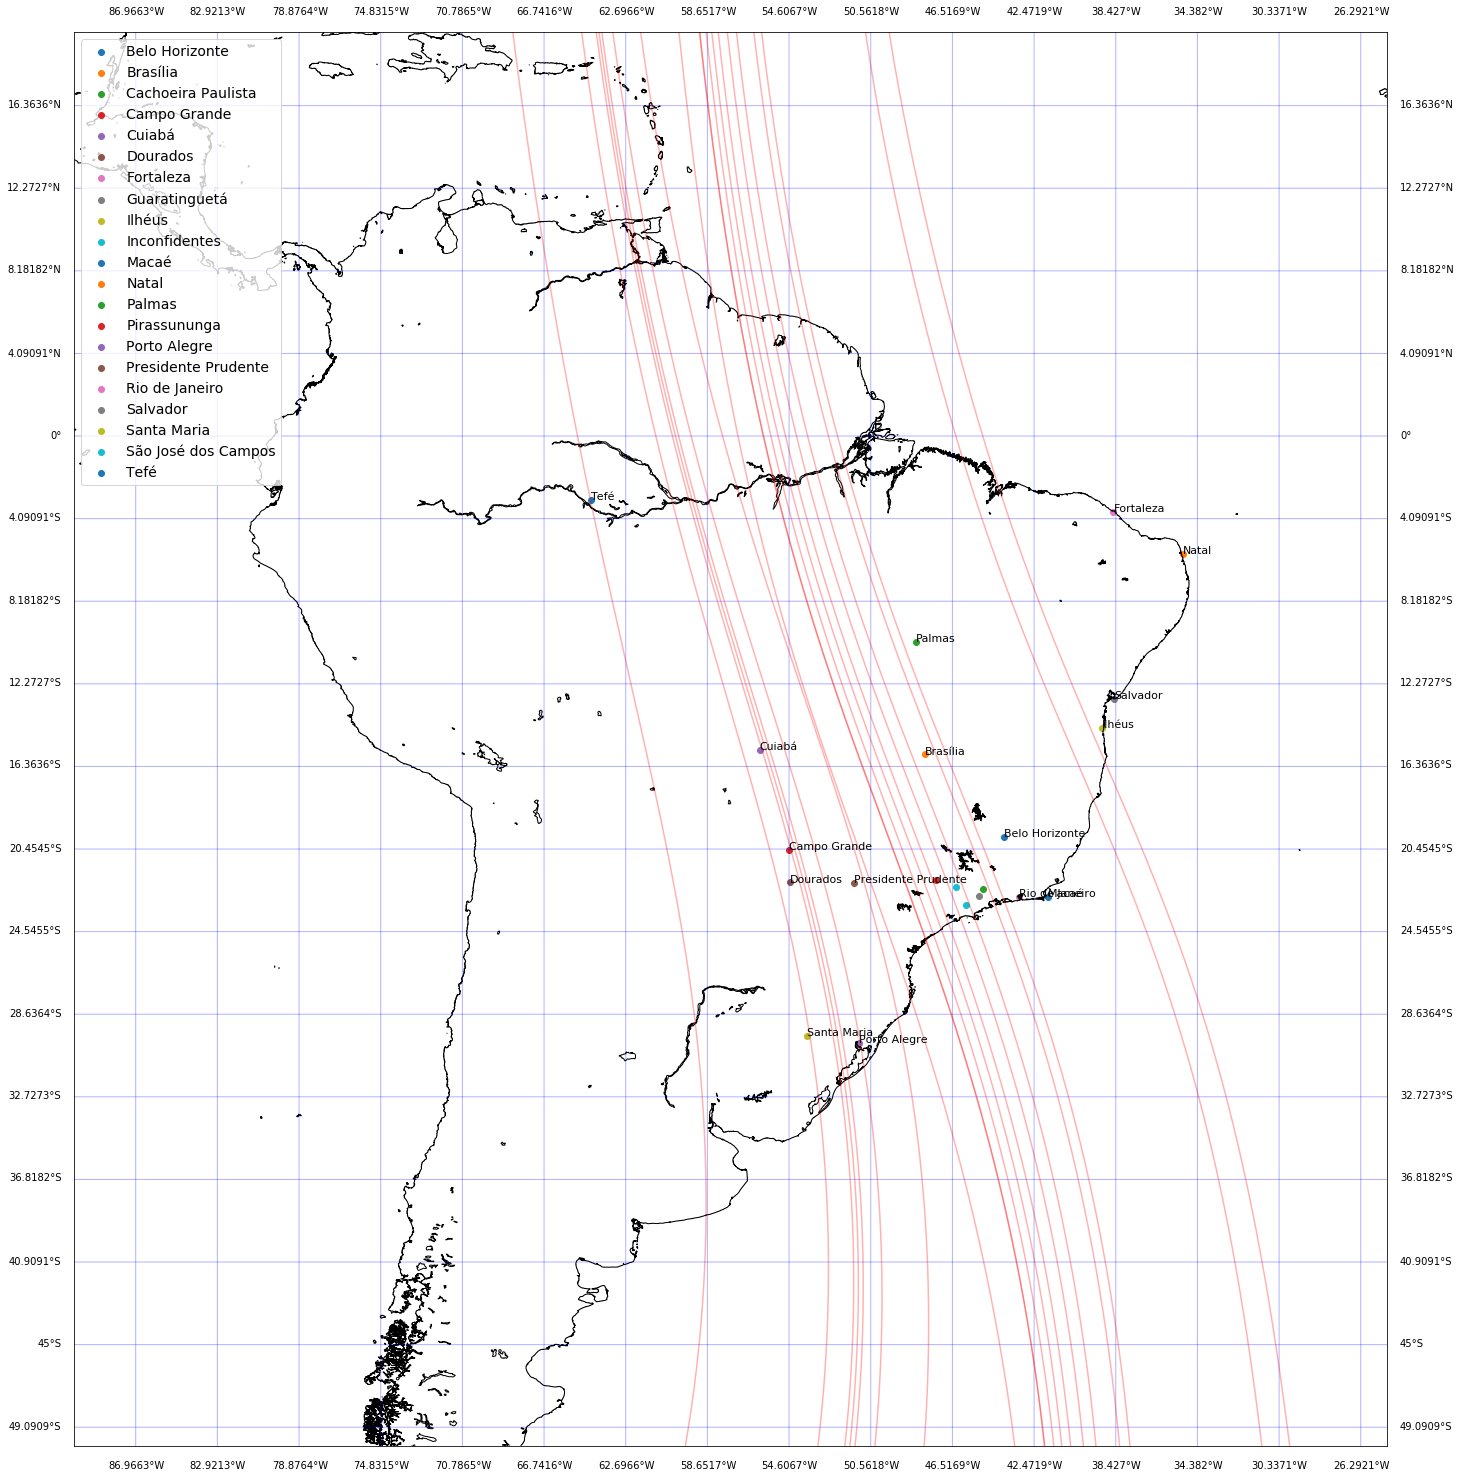

In [20]:
fig = plt.figure(figsize=(26, 26), edgecolor='w')
m = Basemap(projection='cyl',
            resolution='f',
            llcrnrlat=-50,
            urcrnrlat=20,
            llcrnrlon=-90,
            urcrnrlon=-25)
m.drawcoastlines()
#m.readshapefile(os.path.join(local_data, 'estados_2010/estados_2010'), 'estados', )
draw_map(m)

for i in mag_meridians_lines:
    m.plot(i[0], i[1], latlon=True, color='r', alpha=0.3)

for i in df_station.itertuples():
    x, y = m(i.longitude, i.latitude)
    m.scatter(x, y, label=i.Index)
    if i.Index not in ['São José dos Campos', 'Cachoeira Paulista', 'Guaratinguetá', 'Inconfidentes', 'Pirassununga']:
        plt.text(x, y, i.Index, fontsize=11)

plt.legend()
plt.savefig('./images/map_stations_re.svg', format='svg', dpi=1000)
plt.show()

In [21]:
df_station.shape

(21, 11)

In [22]:
df_series_s4_class = pd.DataFrame(index=df_series_s4.index.values)
for i in df_series_s4.columns.values:

SyntaxError: unexpected EOF while parsing (<ipython-input-22-b6295cad1b81>, line 2)